### Motivating Problem

- A firm sends customers a catalog.
- 90% receive the catalog (treatment); 10% are held out.
- Goal: Estimate the causal effect of sending a catalog ($W$) on buying behavior ($Y$).
- Decide who should be targeted to maximize profit.

### Traditional Method

- Classical (Naive) CRM:
  - Predict $\mathbb{E}[Y \mid X, W=1]$ via simple OLS/logit.
  - Target a customer if  
    $m \cdot \mathbb{E}[Y \mid X, W=1] > c$  
    where $m$ is margin and $c$ is cost.
  - Ignores treatment effect $\tau(x)$ and focuses only on predicted level.

### Alternative Approaches

- S-learner:
  - Single model $f(X, W)$.
  - Estimate $\hat{\tau}(x) = f(x,1) - f(x,0)$.

- T-learner:
  - Two separate models: $\hat{f}_1(x)$ for $W=1$ and $\hat{f}_0(x)$ for $W=0$.
  - $\hat{\tau}(x) = \hat{f}_1(x) - \hat{f}_0(x)$.

- Linear CATE:
  - Directly regress $Y_1 - Y_0$ on $X$.
  - $\hat{\tau}(x) = \beta_0 + \beta_1 x$, etc.

- Predictive:
  - Model $\mathbb{E}[Y \mid X, W]$ without separating treatment effect.
  - Ranks customers by predicted outcome level.

Each method scores customers by an estimated $\tau(x)$ (or $\mathbb{E}[Y]$), then targets if  
$m \cdot \hat{\tau}(x) - \text{cost} > 0$  
(or similarly for the predictive approach).

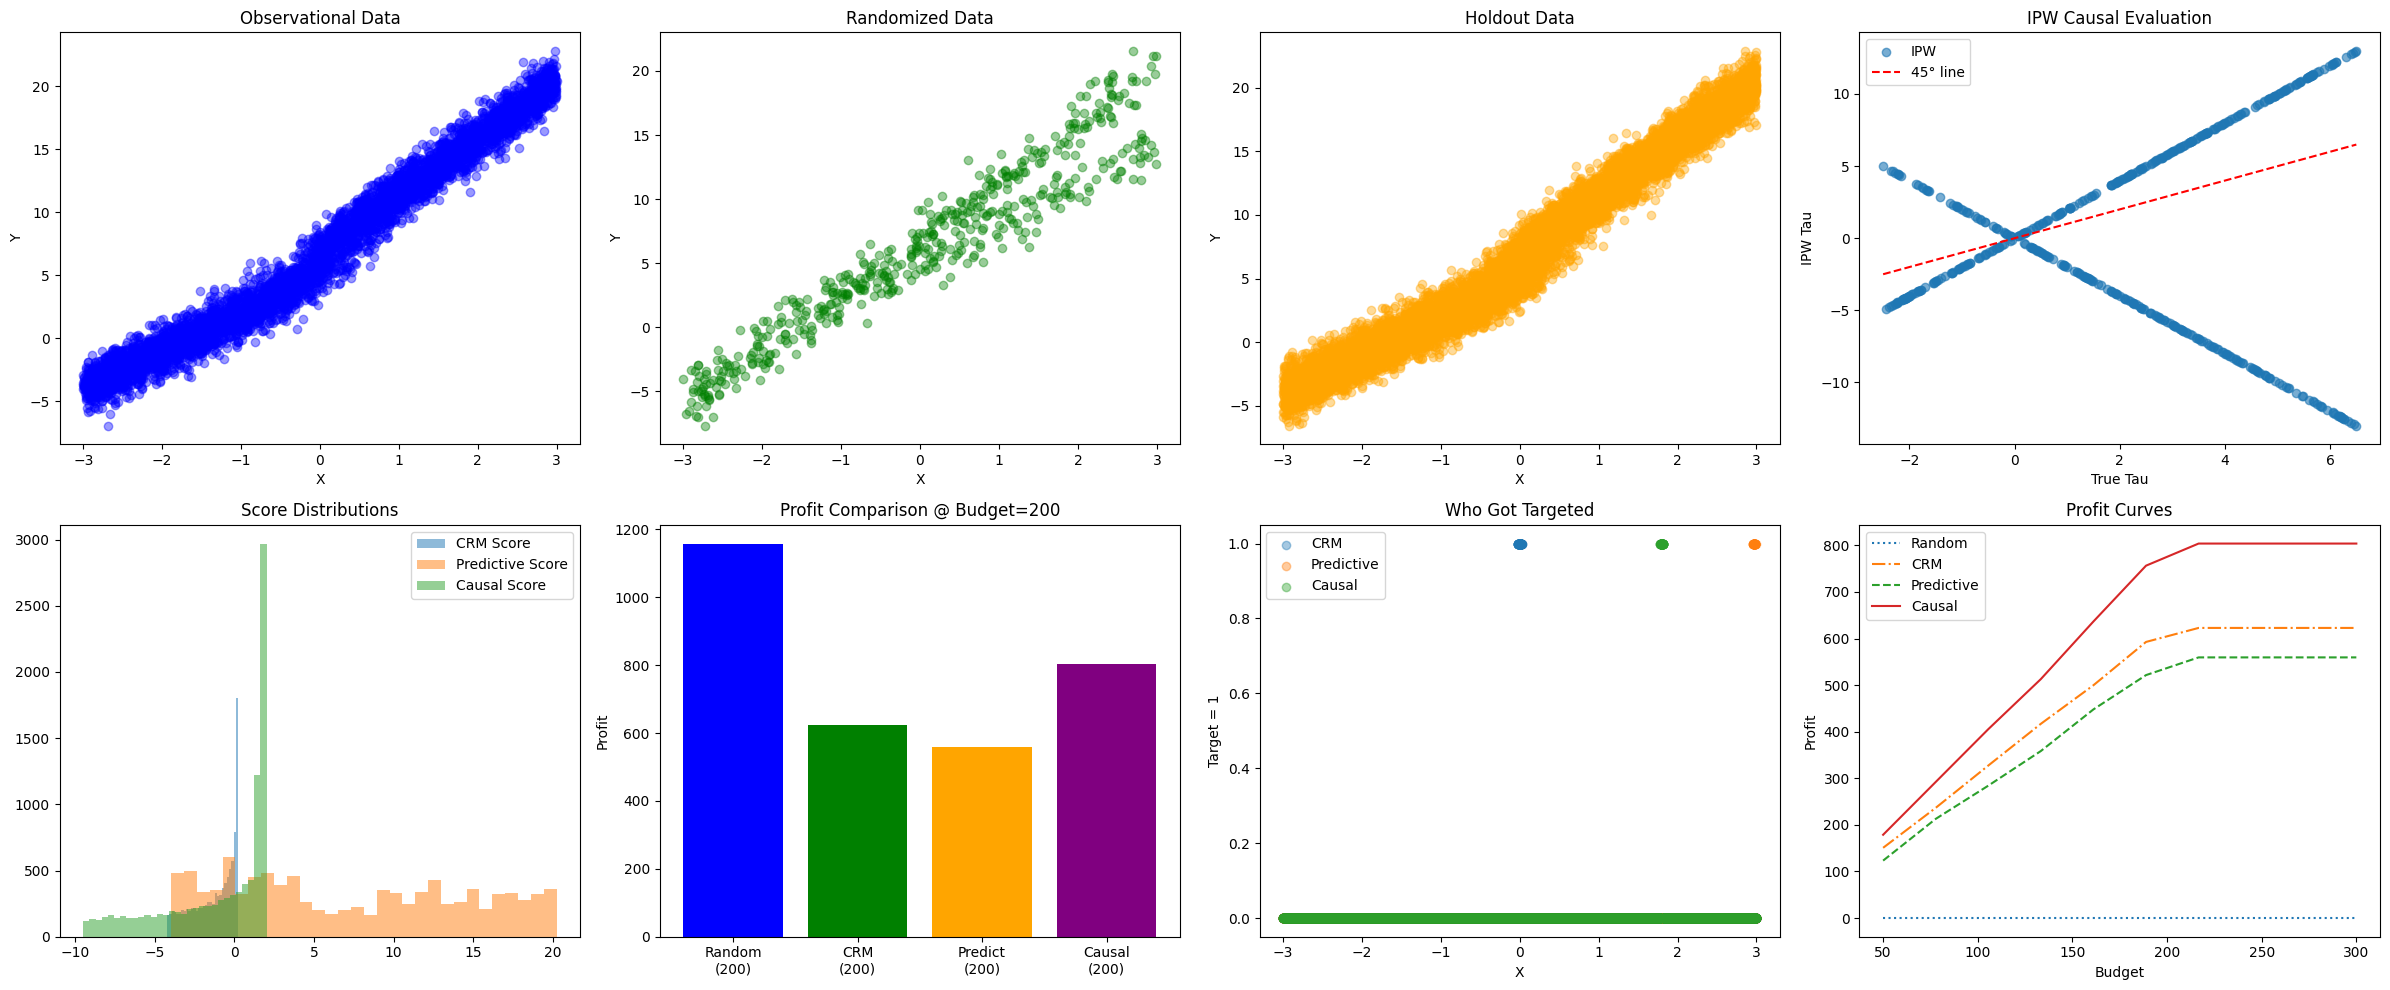


=== Final Max Profits (from Profit Curves) ===
       Method   MaxProfit
0      Random    0.000000
1         CRM  622.812972
2  Predictive  559.539071
3      Causal  803.961256

IPW Estimated Treatment Effect: 0.22


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

np.random.seed(42)

# --- 1. DATA GENERATION ---
def generate_data(N, randomized=True):
    X = np.random.uniform(-3, 3, N)
    if randomized:
        W = np.random.binomial(1, 0.5, N)
        p = 0.5
    else:
        p = 1 / (1 + np.exp(-5*X))  
        W = np.random.binomial(1, p, N)
    epsilon = np.random.normal(0, 1, N)
    
    Y0 = 5 + 3*X + epsilon
    Y1 = 5 + 3*X + 2 + 1.5*X + epsilon
    Y  = W*Y1 + (1 - W)*Y0
    cost = 2 + 0.5*(X**2)
    
    return pd.DataFrame({
        'X': X, 'W': W, 'Y': Y, 'Y0': Y0, 'Y1': Y1, 
        'cost': cost, 'p': p
    })

# Generate data
obs_data = generate_data(5000, randomized=False)
rand_data = generate_data(500, randomized=True)
holdout_data = generate_data(10000, randomized=False)

# --- 2. RANDOM TARGETING ---
holdout_data['rand_target'] = np.random.uniform(size=len(holdout_data)) < (200 / len(holdout_data))
holdout_data['rand_profit'] = holdout_data['rand_target'] * (1.2*holdout_data['Y1'] - holdout_data['cost'])
random_profit_200 = holdout_data['rand_profit'].sum()

# --- 3. CRM (TREATMENT EFFECT) ---
crm_model = LinearRegression()
crm_model.fit(obs_data[['X','W']], obs_data['Y'])
holdout_data['crm_Y1'] = crm_model.predict(holdout_data.assign(W=1)[['X','W']])
holdout_data['crm_Y0'] = crm_model.predict(holdout_data.assign(W=0)[['X','W']])
holdout_data['crm_tau_hat'] = holdout_data['crm_Y1'] - holdout_data['crm_Y0']
holdout_data['crm_score'] = 1.2*holdout_data['crm_tau_hat'] - holdout_data['cost']
holdout_data = holdout_data.sort_values('crm_score', ascending=False).reset_index(drop=True)
holdout_data['cum_cost_crm'] = holdout_data['cost'].cumsum()
holdout_data['crm_target'] = holdout_data['cum_cost_crm'] <= 200
holdout_data['crm_profit'] = holdout_data['crm_target'] * (1.2*holdout_data['Y1'] - holdout_data['cost'])
crm_profit_200 = holdout_data['crm_profit'].sum()

# --- 4. PREDICTIVE TARGETING ---
obs_data_train, obs_data_val = train_test_split(obs_data, test_size=0.2, random_state=42)
predictive_model = LGBMRegressor(verbose=-1)
predictive_model.fit(obs_data_train[['X','W']], obs_data_train['Y'])

holdout_data = holdout_data.sort_values('X')  # to reset index order
holdout_data['Y_hat'] = predictive_model.predict(holdout_data[['X','W']])
holdout_data = holdout_data.sort_values('Y_hat', ascending=False).reset_index(drop=True)
holdout_data['cum_cost_pred'] = holdout_data['cost'].cumsum()
holdout_data['pred_target'] = holdout_data['cum_cost_pred'] <= 200
holdout_data['pred_profit'] = holdout_data['pred_target'] * (1.2*holdout_data['Y'] - holdout_data['cost'])
predictive_profit_200 = holdout_data['pred_profit'].sum()

# --- 5. CAUSAL TARGETING ---
causal_model = LinearRegression()
causal_model.fit(obs_data[['X']], obs_data['Y1'] - obs_data['Y0'])
holdout_data['tau_hat'] = causal_model.predict(holdout_data[['X']])
holdout_data['causal_score'] = 1.2*holdout_data['tau_hat'] - holdout_data['cost']
holdout_data = holdout_data.sort_values('causal_score', ascending=False).reset_index(drop=True)
holdout_data['cum_cost_causal'] = holdout_data['cost'].cumsum()
holdout_data['causal_target'] = holdout_data['cum_cost_causal'] <= 200
holdout_data['causal_profit'] = holdout_data['causal_target'] * (1.2*holdout_data['Y1'] - holdout_data['cost'])
causal_profit_200 = holdout_data['causal_profit'].sum()

# --- 6. IPW EVALUATION ---
rand_data['tau_true'] = rand_data['Y1'] - rand_data['Y0']
rand_data['ipw_weight'] = rand_data['W']/rand_data['p'] - (1 - rand_data['W'])/(1 - rand_data['p'])
rand_data['tau_ipw'] = rand_data['ipw_weight'] * rand_data['tau_true']
tau_ipw_est = rand_data['tau_ipw'].mean()

# --- 7. PROFIT CURVES ---
budgets = np.linspace(50, 300, 10)
random_curve, crm_curve, pred_curve, causal_curve = [], [], [], []

for b in budgets:
    random_curve.append(
        holdout_data.loc[holdout_data['cum_cost_pred'] <= b, 'rand_profit'].sum()
    )
    crm_curve.append(
        holdout_data.loc[holdout_data['cum_cost_crm'] <= b, 'crm_profit'].sum()
    )
    pred_curve.append(
        holdout_data.loc[holdout_data['cum_cost_pred'] <= b, 'pred_profit'].sum()
    )
    causal_curve.append(
        holdout_data.loc[holdout_data['cum_cost_causal'] <= b, 'causal_profit'].sum()
    )

# We'll take each method's max profit from the curves
random_max   = max(random_curve)
crm_max      = max(crm_curve)
predict_max  = max(pred_curve)
causal_max   = max(causal_curve)

# --- 8. VISUALIZATIONS (2x4 GRID) ---
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 10))

# (1) Observational Data
axes[0,0].scatter(obs_data['X'], obs_data['Y'], alpha=0.4, color='blue')
axes[0,0].set_title("Observational Data")
axes[0,0].set_xlabel("X")
axes[0,0].set_ylabel("Y")

# (2) Randomized Data
axes[0,1].scatter(rand_data['X'], rand_data['Y'], alpha=0.4, color='green')
axes[0,1].set_title("Randomized Data")
axes[0,1].set_xlabel("X")
axes[0,1].set_ylabel("Y")

# (3) Holdout Data
axes[0,2].scatter(holdout_data['X'], holdout_data['Y'], alpha=0.4, color='orange')
axes[0,2].set_title("Holdout Data")
axes[0,2].set_xlabel("X")
axes[0,2].set_ylabel("Y")

# (4) IPW Scatter
axes[0,3].scatter(rand_data['tau_true'], rand_data['tau_ipw'], alpha=0.6, label="IPW")
tmin, tmax = rand_data['tau_true'].min(), rand_data['tau_true'].max()
axes[0,3].plot([tmin, tmax],[tmin, tmax],'r--',label="45° line")
axes[0,3].set_title("IPW Causal Evaluation")
axes[0,3].set_xlabel("True Tau")
axes[0,3].set_ylabel("IPW Tau")
axes[0,3].legend()

# (5) Score Distributions
axes[1,0].hist(holdout_data['crm_score'], bins=30, alpha=0.5, label="CRM Score")
axes[1,0].hist(holdout_data['Y_hat'], bins=30, alpha=0.5, label="Predictive Score")
axes[1,0].hist(holdout_data['causal_score'], bins=30, alpha=0.5, label="Causal Score")
axes[1,0].set_title("Score Distributions")
axes[1,0].legend()

# (6) Profit Comparison (Bars) - at Budget=200
bars_methods = ["Random\n(200)","CRM\n(200)","Predict\n(200)","Causal\n(200)"]
bars_profits = [random_profit_200, crm_profit_200, predictive_profit_200, causal_profit_200]
axes[1,1].bar(bars_methods, bars_profits, color=['blue','green','orange','purple'])
axes[1,1].set_title("Profit Comparison @ Budget=200")
axes[1,1].set_ylabel("Profit")

# (7) Who Got Targeted
axes[1,2].scatter(holdout_data['X'], holdout_data['crm_target'], alpha=0.4, label="CRM")
axes[1,2].scatter(holdout_data['X'], holdout_data['pred_target'], alpha=0.4, label="Predictive")
axes[1,2].scatter(holdout_data['X'], holdout_data['causal_target'], alpha=0.4, label="Causal")
axes[1,2].set_title("Who Got Targeted")
axes[1,2].set_xlabel("X")
axes[1,2].set_ylabel("Target = 1")
axes[1,2].legend()

# (8) Profit Curves
axes[1,3].plot(budgets, random_curve, label="Random", linestyle=':')
axes[1,3].plot(budgets, crm_curve, label="CRM", linestyle='-.')
axes[1,3].plot(budgets, pred_curve, label="Predictive", linestyle='--')
axes[1,3].plot(budgets, causal_curve, label="Causal", linestyle='-')
axes[1,3].set_xlabel("Budget")
axes[1,3].set_ylabel("Profit")
axes[1,3].set_title("Profit Curves")
axes[1,3].legend()

plt.tight_layout()
plt.show()

# --- 9. TABLE USING MAX PROFITS (from curves) ---
results_df = pd.DataFrame({
    'Method': ['Random', 'CRM', 'Predictive', 'Causal'],
    'MaxProfit': [random_max, crm_max, predict_max, causal_max]
})
print("\n=== Final Max Profits (from Profit Curves) ===")
print(results_df)

# Also show IPW
print(f"\nIPW Estimated Treatment Effect: {tau_ipw_est:.2f}")


## Nonlinearities

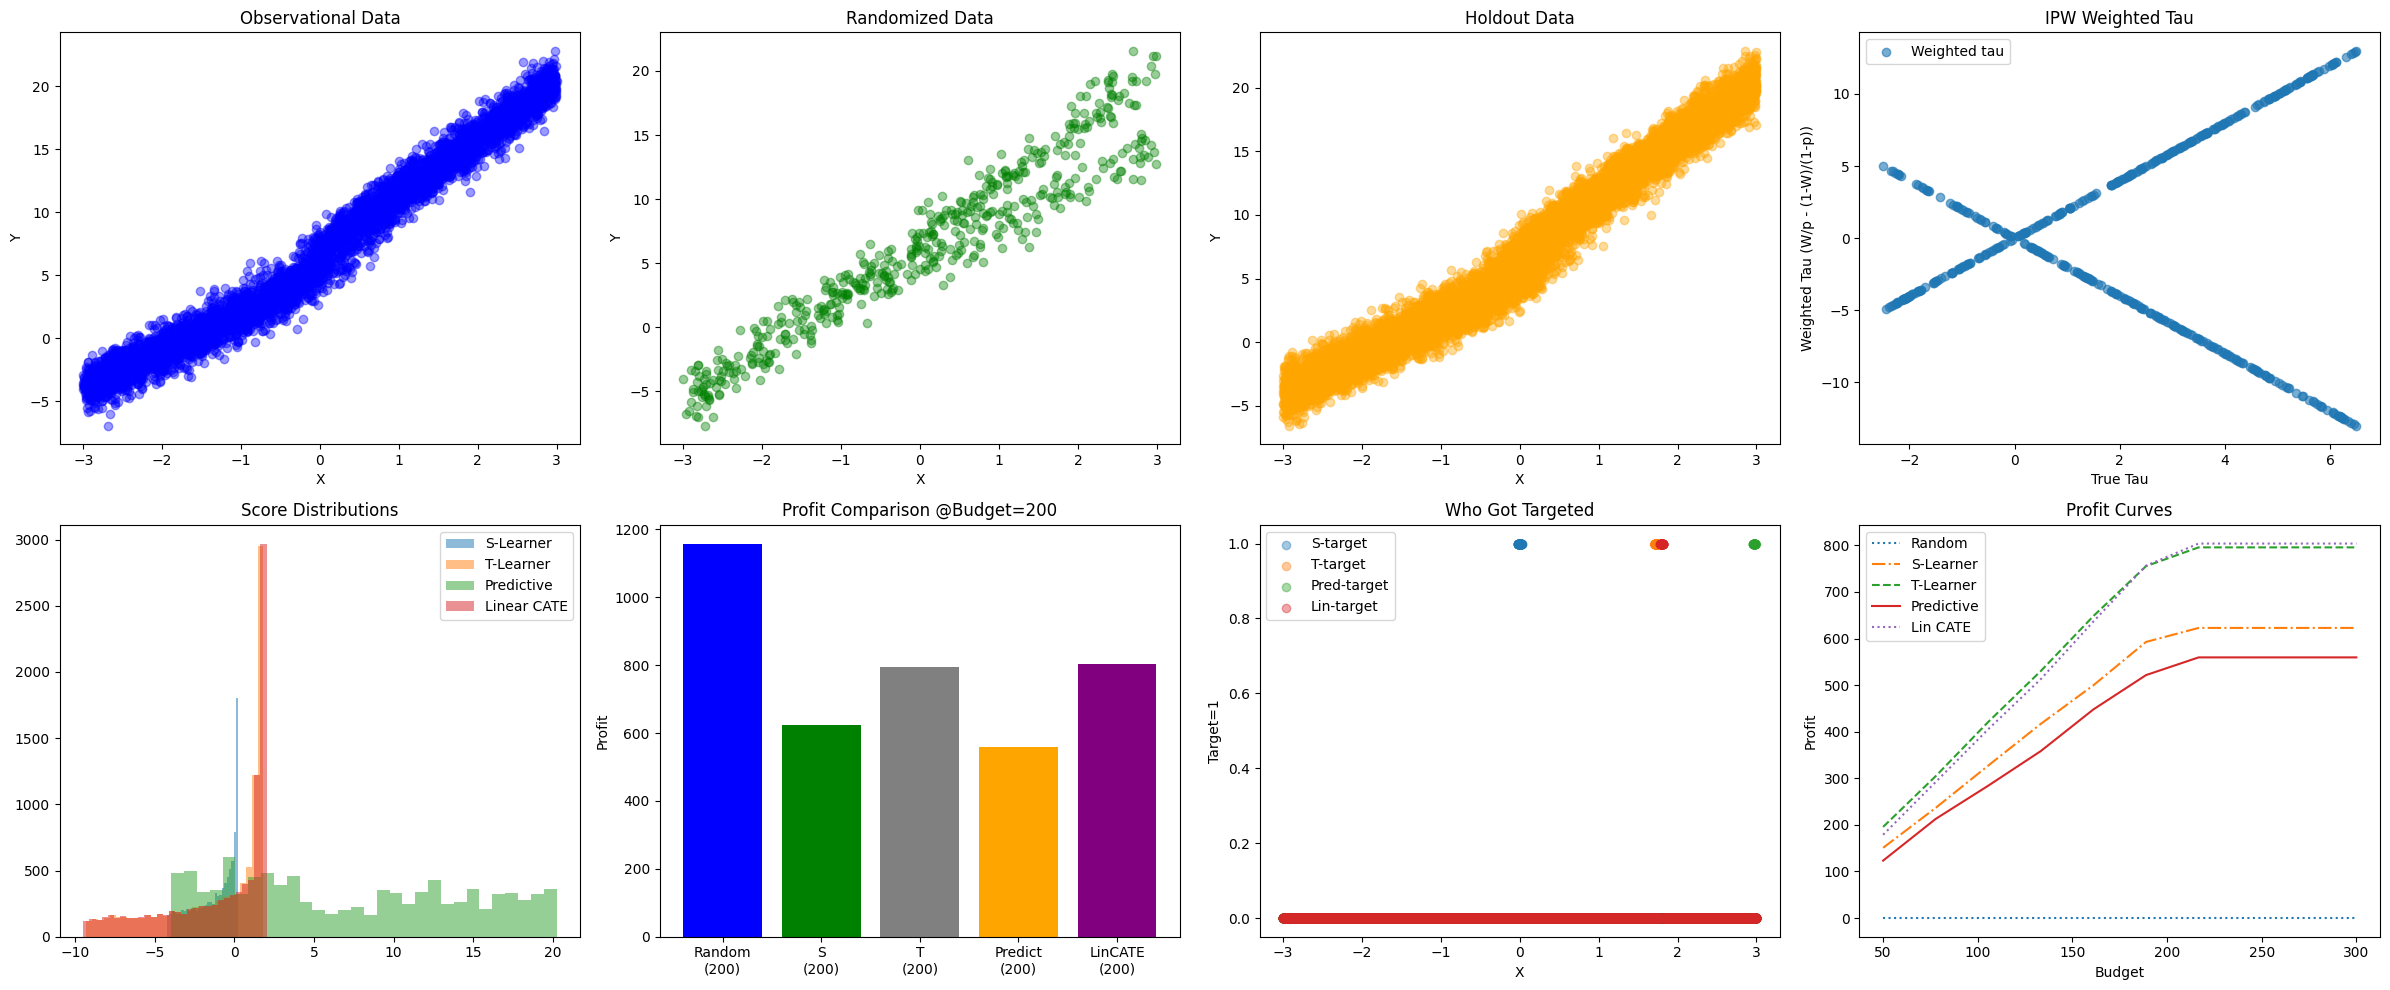


=== Max Profits (from curves) ===
       Method   MaxProfit
0      Random    0.000000
1   S-Learner  622.812972
2   T-Learner  795.762791
3  Predictive  559.539071
4     LinCATE  803.961256

=== IPW MSE (Randomized Data) ===
       Method       IPW MSE
0   S-Learner  1.222081e+00
1   T-Learner  2.013037e-03
2  LinearCATE  1.111217e-29

IPW Estimated Average Treatment Effect: 0.22


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

np.random.seed(42)

# --- 1. DATA GENERATION ---
def generate_data(N, randomized=True):
    X = np.random.uniform(-3, 3, N)
    if randomized:
        W = np.random.binomial(1, 0.5, N)
        p = 0.5
    else:
        # More extreme logit for demonstration
        p = 1 / (1 + np.exp(-5 * X))  
        W = np.random.binomial(1, p, N)
    eps = np.random.normal(0, 1, N)
    
    Y0 = 5 + 3*X + eps
    Y1 = 5 + 3*X + 2 + 1.5*X + eps
    Y  = np.where(W==1, Y1, Y0)
    cost = 2 + 0.5*(X**2)
    
    return pd.DataFrame({
        'X': X, 'W': W, 'Y': Y, 'Y0': Y0, 'Y1': Y1,
        'p': p, 'cost': cost
    })

# Generate data
obs_data = generate_data(5000, randomized=False)
rand_data = generate_data(500, randomized=True)
holdout_data = generate_data(10000, randomized=False)

# --- 2. RANDOM TARGETING (baseline) ---
holdout_data['rand_target'] = (
    np.random.uniform(size=len(holdout_data)) < (200 / len(holdout_data))
)
holdout_data['rand_profit'] = holdout_data['rand_target'] * (1.2*holdout_data['Y1'] - holdout_data['cost'])
random_profit_200 = holdout_data['rand_profit'].sum()

# --- 3. S-LEARNER (was "CRM") ---
s_learner = LinearRegression()
s_learner.fit(obs_data[['X','W']], obs_data['Y'])

# For holdout, predict Y1-hat and Y0-hat, then tau_s
holdout_data['s_Y1'] = s_learner.predict(holdout_data.assign(W=1)[['X','W']])
holdout_data['s_Y0'] = s_learner.predict(holdout_data.assign(W=0)[['X','W']])
holdout_data['tau_s'] = holdout_data['s_Y1'] - holdout_data['s_Y0']
holdout_data['s_score'] = 1.2*holdout_data['tau_s'] - holdout_data['cost']
holdout_data = holdout_data.sort_values('s_score', ascending=False).reset_index(drop=True)
holdout_data['cum_cost_s'] = holdout_data['cost'].cumsum()
holdout_data['s_target'] = holdout_data['cum_cost_s'] <= 200
holdout_data['s_profit'] = holdout_data['s_target'] * (1.2*holdout_data['Y1'] - holdout_data['cost'])
s_profit_200 = holdout_data['s_profit'].sum()

# --- 4. T-LEARNER ---
obs_1 = obs_data[obs_data['W'] == 1]
obs_0 = obs_data[obs_data['W'] == 0]
t_model_1 = LinearRegression().fit(obs_1[['X']], obs_1['Y'])
t_model_0 = LinearRegression().fit(obs_0[['X']], obs_0['Y'])

holdout_data = holdout_data.sort_values('X')  # just to reset for next steps
t_pred_1 = t_model_1.predict(holdout_data[['X']])
t_pred_0 = t_model_0.predict(holdout_data[['X']])
holdout_data['tau_t'] = t_pred_1 - t_pred_0
holdout_data['t_score'] = 1.2*holdout_data['tau_t'] - holdout_data['cost']
holdout_data = holdout_data.sort_values('t_score', ascending=False).reset_index(drop=True)
holdout_data['cum_cost_t'] = holdout_data['cost'].cumsum()
holdout_data['t_target'] = holdout_data['cum_cost_t'] <= 200
holdout_data['t_profit'] = holdout_data['t_target'] * (1.2*holdout_data['Y1'] - holdout_data['cost'])
t_profit_200 = holdout_data['t_profit'].sum()

# --- 5. PREDICTIVE LEARNER (LightGBM on Y) ---
obs_train, obs_val = train_test_split(obs_data, test_size=0.2, random_state=42)
pred_model = LGBMRegressor(verbose=-1)
pred_model.fit(obs_train[['X','W']], obs_train['Y'])

holdout_data = holdout_data.sort_values('X')  # reset index order
holdout_data['Y_hat'] = pred_model.predict(holdout_data[['X','W']])
holdout_data = holdout_data.sort_values('Y_hat', ascending=False).reset_index(drop=True)
holdout_data['cum_cost_pred'] = holdout_data['cost'].cumsum()
holdout_data['pred_target'] = holdout_data['cum_cost_pred'] <= 200
holdout_data['pred_profit'] = holdout_data['pred_target'] * (1.2*holdout_data['Y'] - holdout_data['cost'])
predictive_profit_200 = holdout_data['pred_profit'].sum()

# --- 6. LINEAR CATE (previous "causal") ---
lin_cate = LinearRegression()
lin_cate.fit(obs_data[['X']], obs_data['Y1'] - obs_data['Y0'])
holdout_data['tau_lin'] = lin_cate.predict(holdout_data[['X']])
holdout_data['lin_score'] = 1.2*holdout_data['tau_lin'] - holdout_data['cost']
holdout_data = holdout_data.sort_values('lin_score', ascending=False).reset_index(drop=True)
holdout_data['cum_cost_lin'] = holdout_data['cost'].cumsum()
holdout_data['lin_target'] = holdout_data['cum_cost_lin'] <= 200
holdout_data['lin_profit'] = holdout_data['lin_target'] * (1.2*holdout_data['Y1'] - holdout_data['cost'])
lin_profit_200 = holdout_data['lin_profit'].sum()

# --- 7. IPW EVALUATION (S, T, Linear) ---
rand_data['tau_true'] = rand_data['Y1'] - rand_data['Y0']
rand_data['ipw_weight'] = rand_data['W']/rand_data['p'] - (1 - rand_data['W'])/(1 - rand_data['p'])

# Get tau predictions from each method
# (Predictive doesn't produce tau; random doesn't either)
# S-learner
tmp_s1 = s_learner.predict(rand_data.assign(W=1)[['X','W']])
tmp_s0 = s_learner.predict(rand_data.assign(W=0)[['X','W']])
rand_data['tau_s'] = tmp_s1 - tmp_s0
# T-learner
tmp_t1 = t_model_1.predict(rand_data[['X']])
tmp_t0 = t_model_0.predict(rand_data[['X']])
rand_data['tau_t'] = tmp_t1 - tmp_t0
# Linear CATE
rand_data['tau_lin'] = lin_cate.predict(rand_data[['X']])

def ipw_mse(df, pred_col):
    # Weighted MSE: sum( w_i * (tau_true - tau_pred)^2 ) / sum(|w_i|)
    num = np.sum(df['ipw_weight'] * (df['tau_true'] - df[pred_col])**2)
    den = np.sum(abs(df['ipw_weight']))
    return num / den

mse_s   = ipw_mse(rand_data, 'tau_s')
mse_t   = ipw_mse(rand_data, 'tau_t')
mse_lin = ipw_mse(rand_data, 'tau_lin')

# --- 8. PROFIT CURVES ---
budgets = np.linspace(50, 300, 10)

# For each budget, sum the profits of each approach
random_curve, s_curve, t_curve, pred_curve, lin_curve = [], [], [], [], []

for b in budgets:
    sub_rand = holdout_data.loc[holdout_data['cum_cost_pred'] <= b, 'rand_profit'].sum()
    sub_s    = holdout_data.loc[holdout_data['cum_cost_s']    <= b, 's_profit'].sum()
    sub_t    = holdout_data.loc[holdout_data['cum_cost_t']    <= b, 't_profit'].sum()
    sub_pred = holdout_data.loc[holdout_data['cum_cost_pred'] <= b, 'pred_profit'].sum()
    sub_lin  = holdout_data.loc[holdout_data['cum_cost_lin']  <= b, 'lin_profit'].sum()
    
    random_curve.append(sub_rand)
    s_curve.append(sub_s)
    t_curve.append(sub_t)
    pred_curve.append(sub_pred)
    lin_curve.append(sub_lin)

random_max = max(random_curve)
s_max      = max(s_curve)
t_max      = max(t_curve)
pred_max   = max(pred_curve)
lin_max    = max(lin_curve)

# --- 9. 2x4 GRID OF PLOTS ---
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24,10))

# (1) Observational Data
axes[0,0].scatter(obs_data['X'], obs_data['Y'], alpha=0.4, color='blue')
axes[0,0].set_title("Observational Data")
axes[0,0].set_xlabel("X")
axes[0,0].set_ylabel("Y")

# (2) Randomized Data
axes[0,1].scatter(rand_data['X'], rand_data['Y'], alpha=0.4, color='green')
axes[0,1].set_title("Randomized Data")
axes[0,1].set_xlabel("X")
axes[0,1].set_ylabel("Y")

# (3) Holdout Data
axes[0,2].scatter(holdout_data['X'], holdout_data['Y'], alpha=0.4, color='orange')
axes[0,2].set_title("Holdout Data")
axes[0,2].set_xlabel("X")
axes[0,2].set_ylabel("Y")

# (4) IPW Scatter
axes[0,3].scatter(rand_data['tau_true'], rand_data['ipw_weight']*(rand_data['tau_true']), 
                  alpha=0.6, label="Weighted tau")
axes[0,3].set_title("IPW Weighted Tau")
axes[0,3].set_xlabel("True Tau")
axes[0,3].set_ylabel("Weighted Tau (W/p - (1-W)/(1-p))")
axes[0,3].legend()

# (5) Score Distributions (S, T, Predictive, Linear)
axes[1,0].hist(holdout_data['s_score'], bins=30, alpha=0.5, label="S-Learner")
axes[1,0].hist(holdout_data['t_score'], bins=30, alpha=0.5, label="T-Learner")
axes[1,0].hist(holdout_data['Y_hat'],  bins=30, alpha=0.5, label="Predictive")
axes[1,0].hist(holdout_data['lin_score'], bins=30, alpha=0.5, label="Linear CATE")
axes[1,0].set_title("Score Distributions")
axes[1,0].legend()

# (6) Profit @200 (Bar Chart)
methods_200 = ["Random\n(200)","S\n(200)","T\n(200)","Predict\n(200)","LinCATE\n(200)"]
profits_200 = [random_profit_200, s_profit_200, t_profit_200, predictive_profit_200, lin_profit_200]
axes[1,1].bar(methods_200, profits_200, color=['blue','green','gray','orange','purple'])
axes[1,1].set_title("Profit Comparison @Budget=200")
axes[1,1].set_ylabel("Profit")

# (7) Who Got Targeted (S, T, Pred, Lin)
axes[1,2].scatter(holdout_data['X'], holdout_data['s_target'], alpha=0.4, label="S-target")
axes[1,2].scatter(holdout_data['X'], holdout_data['t_target'], alpha=0.4, label="T-target")
axes[1,2].scatter(holdout_data['X'], holdout_data['pred_target'], alpha=0.4, label="Pred-target")
axes[1,2].scatter(holdout_data['X'], holdout_data['lin_target'], alpha=0.4, label="Lin-target")
axes[1,2].set_title("Who Got Targeted")
axes[1,2].set_xlabel("X")
axes[1,2].set_ylabel("Target=1")
axes[1,2].legend()

# (8) Profit Curves
axes[1,3].plot(budgets, random_curve, label="Random", linestyle=':')
axes[1,3].plot(budgets, s_curve,      label="S-Learner", linestyle='-.')
axes[1,3].plot(budgets, t_curve,      label="T-Learner", linestyle='--')
axes[1,3].plot(budgets, pred_curve,   label="Predictive", linestyle='-')
axes[1,3].plot(budgets, lin_curve,    label="Lin CATE", linestyle=':')
axes[1,3].set_xlabel("Budget")
axes[1,3].set_ylabel("Profit")
axes[1,3].set_title("Profit Curves")
axes[1,3].legend()

plt.tight_layout()
plt.show()

# --- 10. FINAL TABLES ---
# A) Max profit from curves
results_df = pd.DataFrame({
    'Method'   : ["Random","S-Learner","T-Learner","Predictive","LinCATE"],
    'MaxProfit': [random_max, s_max, t_max, pred_max, lin_max]
})
print("\n=== Max Profits (from curves) ===")
print(results_df)

# B) IPW MSE for tau predictions
ipw_df = pd.DataFrame({
    'Method': ["S-Learner","T-Learner","LinearCATE"],
    'IPW MSE': [mse_s, mse_t, mse_lin]
})
print("\n=== IPW MSE (Randomized Data) ===")
print(ipw_df)

# Also show average IPW estimate of the true effect
rand_data['tau_ipw'] = rand_data['ipw_weight'] * rand_data['tau_true']
tau_ipw_est = rand_data['tau_ipw'].mean()
print(f"\nIPW Estimated Average Treatment Effect: {tau_ipw_est:.2f}")
